# IoT Planning 

**Input**: data from telco's customers with demographic, services and account information.

**Output**: flask application with form to be filled with customer's information. The application should return with the prediction result if the customer will or will not churn in that month.

**Tasks**:
- data description
- end-to-end solution
- metrics definition
- data cleaning
- check the unbalency
- feature engineering
- eda
- data preparation
- feature selection
- ml models
- hyperparameters fine tuning
- deploy

# 0.0 Imports

In [82]:
from IPython.core.display      import HTML
from IPython.display           import Image
from pycaret.classification    import *
from pandas_profiling          import ProfileReport
from pprint                    import pprint

from scikitplot                import metrics         as mt
from sklearn                   import model_selection as ms
from sklearn                   import preprocessing   as pp
from sklearn                   import metrics         as m
from keras                     import models          as ml
from keras                     import layers          as l
from scipy                     import stats           as ss
from sklearn.preprocessing     import LabelEncoder
from imblearn                  import under_sampling  as us
from imblearn                  import over_sampling   as oversamp
from imblearn                  import combine         as c
from sklearn.preprocessing     import MinMaxScaler, RobustScaler
from sklearn.linear_model      import RidgeClassifier, LogisticRegression
from sklearn.svm               import SVC
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.tree              import DecisionTreeClassifier
from sklearn.ensemble          import RandomForestClassifier
from sklearn.naive_bayes       import GaussianNB
from sklearn.metrics           import accuracy_score, balanced_accuracy_score, recall_score, classification_report, confusion_matrix, f1_score, cohen_kappa_score, roc_curve
from sklearn.model_selection   import train_test_split, cross_val_score, ShuffleSplit, RandomizedSearchCV

import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
import numpy             as np

import inflection

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set

jupyter_settings()

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def ml_error(model_name, y, yhat):
    acc = accuracy_score(y_test, y_pred)
    fscore = f1_score(y_test, y_pred)
    balancedacc = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return pd.DataFrame({'Model Name': model_name,
                        'ACC': acc,
                        'F1-SCORE': fscore,
                        'BALANCED ACC': balancedacc,
                        'KAPPA SCORE': kappa}, index = [0])

def cross_validation(model_name, model):
    n_samples = x_training.shape[0]
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    scores = cross_val_score(model, x_training[selected], x_training['churn'], cv=cv)
    return pd.DataFrame({'Model Name': model_name,
                         'ACC CV': np.round(scores.mean(), 3).astype(str) + ' +/- ' + np.round(scores.std(), 4).astype(str)}, index=[0]) 

#def cross_validation(x_training, kfold, model_name, model, verbose=False):
#    acc_list = []
#    auc_list = []
#    cm_list = []
#    fscore_list = []
#    balancedacc_list = []
#    kappa_list = []
#    for k in reversed(range(1, kfold+1)):
#        if verbose:
#            print('\nKFold Number: {}'.format(k))
#        
#        #training
#        xtraining = x_training.drop(['churn'], axis=1)
#        ytraining = x_training['churn']
#        
#        #validation
#        xvalidation = x_training.drop(['churn'], axis=1)
#        yvalidation = x_training['churn']
#        
#        #model
#        m = model.fit(xtraining, ytraining)
#        
#        #prediction
#        yhat = m.predict(xvalidation)
#        
#        #performance
#        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
#        
#        #store performance of each kfold iteration
#        acc_list.append(m_result['ACC'])
#        fscore_list.append(m_result['F1-SCORE'])
#        balancedacc_list.append(m_result['BALANCED ACC'])
#        kappa_list.append(m_result['KAPPA SCORE'])
#        
#    return pd.DataFrame({'Model Name': model_name,
#                        'ACC CV': np.mean(acc_list),
#                        'F1-SCORE CV': np.mean(fscore_list),
#                        'BALANCED ACC CV': np.mean(balancedacc_list),
#                        'KAPPA SCORE CV': np.mean(kappa_list)}, index=[0]) 

Populating the interactive namespace from numpy and matplotlib


In [4]:
pd.options.display.float_format = '{:,.2f}'.format

## 0.2 Load Data

In [5]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# 1.0 Data Description

In [6]:
df1 = df_train.copy()

## 1.1 Data Dimension

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 5634
Number of columns: 21


## 1.2 Rename Columns

In [8]:
cols_old = ['id', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
            'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
            'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
            'MonthlyCharges', 'TotalCharges', 'Churn']
snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, cols_old))
df1.columns = new_cols

In [9]:
cols_old = ['id', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges']
snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, cols_old))
df_test.columns = new_cols

## 1.3 Data Types

In [10]:
df1.dtypes

id                     int64
gender                object
senior_citizen         int64
partner               object
dependents            object
tenure               float64
phone_service         object
multiple_lines        object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
contract              object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges         object
churn                  int64
dtype: object

## 1.4 Check N/A

In [11]:
df1.isna().sum()

id                     0
gender                 0
senior_citizen         0
partner                0
dependents           218
tenure               461
phone_service          0
multiple_lines         0
internet_service       0
online_security        0
online_backup          0
device_protection      0
tech_support           0
streaming_tv           0
streaming_movies       0
contract               0
paperless_billing      0
payment_method        99
monthly_charges        0
total_charges          0
churn                  0
dtype: int64

## 1.5 Check Balanced Data

In [12]:
df1['churn'].value_counts(normalize=True)

0   0.73
1   0.27
Name: churn, dtype: float64

## 1.5 Replace N/A

In [13]:
#dependents > replace with No
df1.loc[df1['dependents'].isna(), 'dependents'] = 'No'
#tenure > replace with mean
df1.loc[df1['tenure'].isna(), 'tenure'] = 32.0
#payment_method > replace with "Not specified"
df1.loc[df1['payment_method'].isna(), 'payment_method'] = 'Not specified'

## 1.6 Change Data Types

In [14]:
df1['total_charges'] = pd.to_numeric(df1['total_charges'], errors='coerce')
df1['tenure'] = df1['tenure'].astype(int)
df1['total_charges'] = df1['total_charges'].astype(float)

In [15]:
df_test['total_charges'] = pd.to_numeric(df_test['total_charges'], errors='coerce')
df_test['tenure'] = df1['tenure'].astype(int)
df_test['total_charges'] = df1['total_charges'].astype(float)

## 1.7 Statistics Description

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.7.1  Numerical Attributes 

In [17]:
#central tendency (mean, median)
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion (std, min, max, range, skew, kurtosis)
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#final dataset
num_desc = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
num_desc.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
num_desc

attributes   min      max    range     mean   median      std  skew  kurtosis
0               id  1.00 7,043.00 7,042.00 3,530.31 3,525.50 2,036.01  0.00     -1.20
1   senior_citizen  0.00     1.00     1.00     0.16     0.00     0.37  1.87      1.49
2  monthly_charges 18.25   118.75   100.50    64.63    70.25    30.02 -0.22     -1.26
3    total_charges 18.80 8,684.80 8,666.00 2,273.51      NaN 2,258.18  0.97     -0.21
4            churn  0.00     1.00     1.00     0.27     0.00     0.44  1.06     -0.87

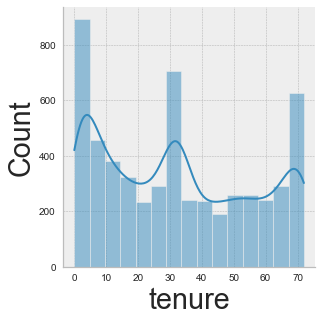

In [18]:
a = sns.displot(data=df1, x='tenure', kde=True);
plt.show();

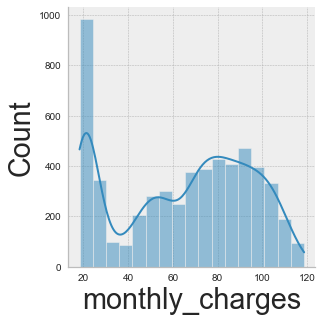

In [19]:
a = sns.displot(data=df1, x='monthly_charges', kde=True);
plt.show();

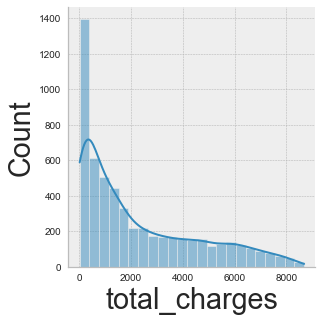

In [20]:
a = sns.displot(data=df1, x='total_charges', kde=True);
plt.show();

### 1.7.2 Categorical Attributes 

In [21]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender                2
partner               2
dependents            2
tenure               73
phone_service         2
multiple_lines        3
internet_service      3
online_security       3
online_backup         3
device_protection     3
tech_support          3
streaming_tv          3
streaming_movies      3
contract              3
paperless_billing     2
payment_method        5
dtype: int64

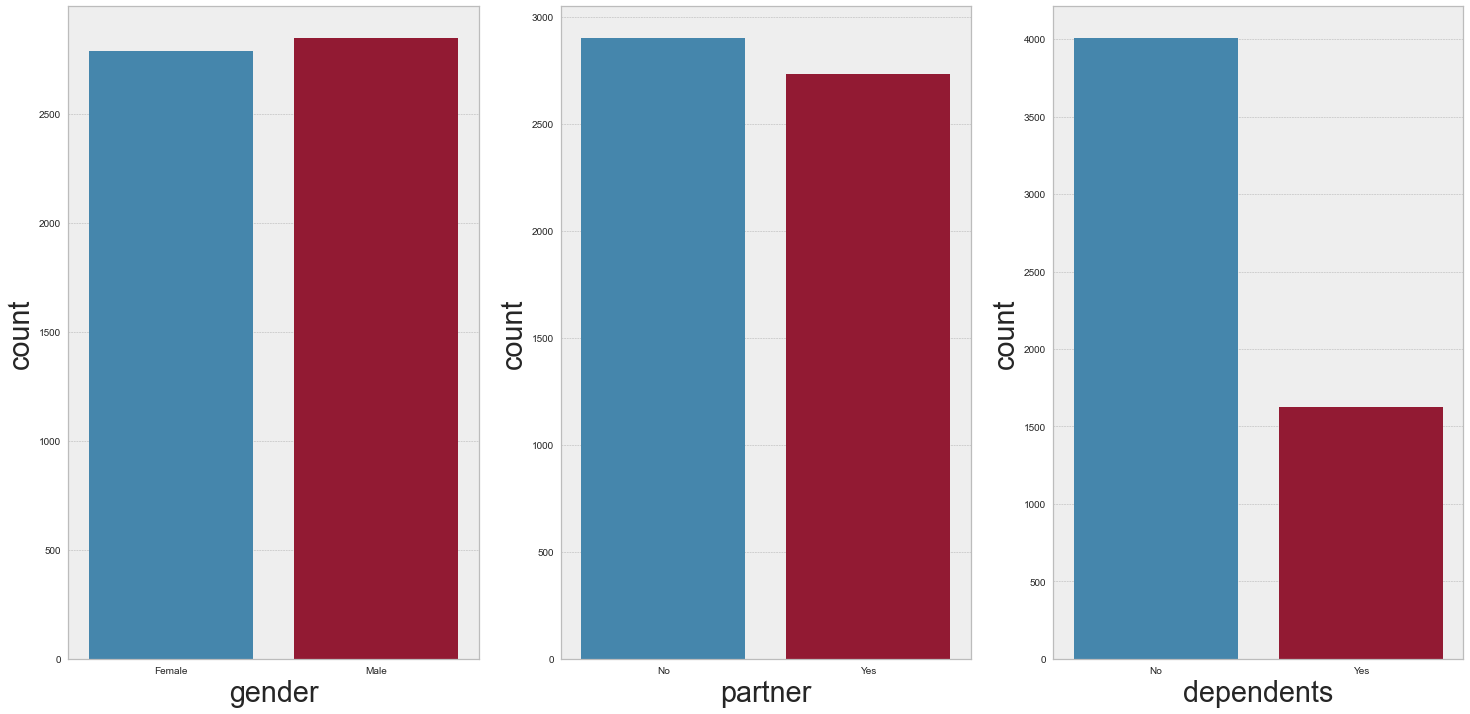

In [22]:
plt.subplot(1, 3, 1)
sns.countplot(df1['gender'])

plt.subplot(1, 3, 2)
sns.countplot(df1['partner'])

plt.subplot(1, 3, 3)
sns.countplot(df1['dependents'])
plt.show()

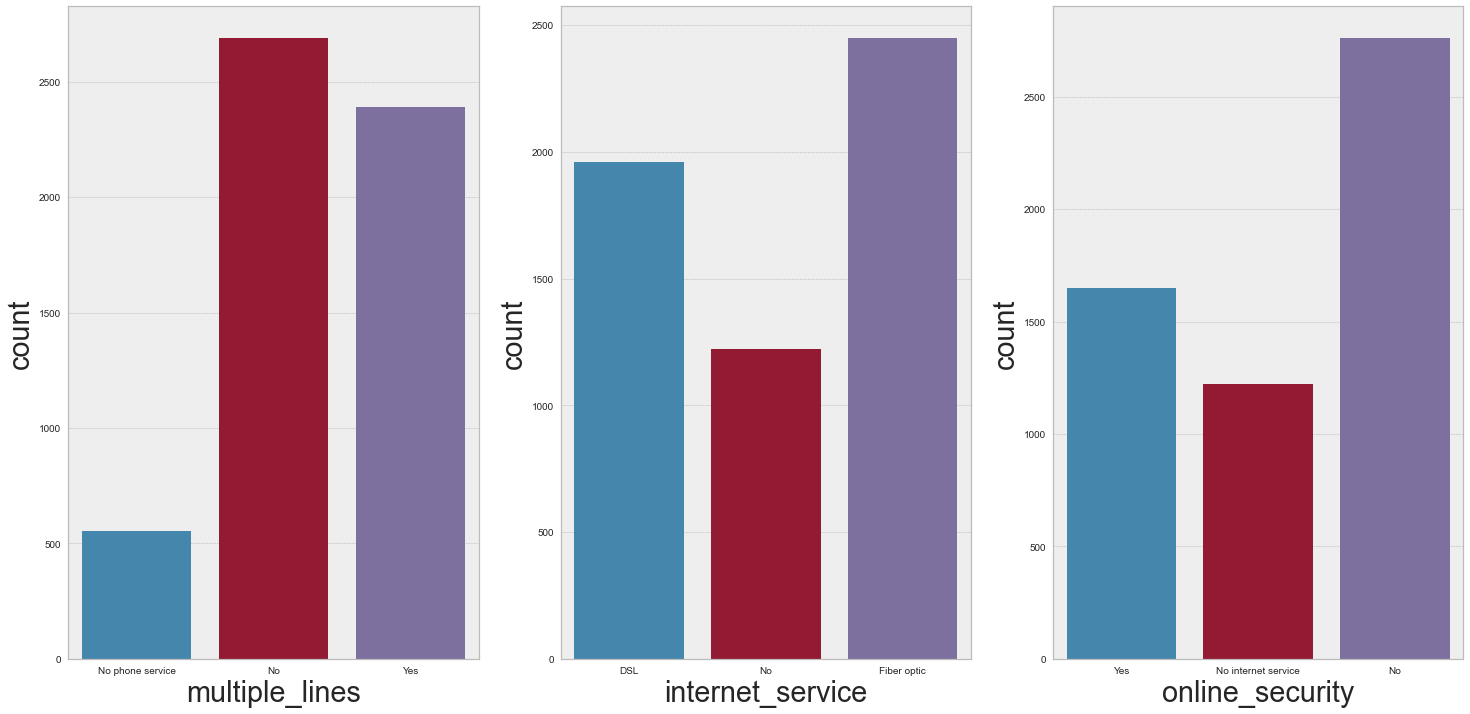

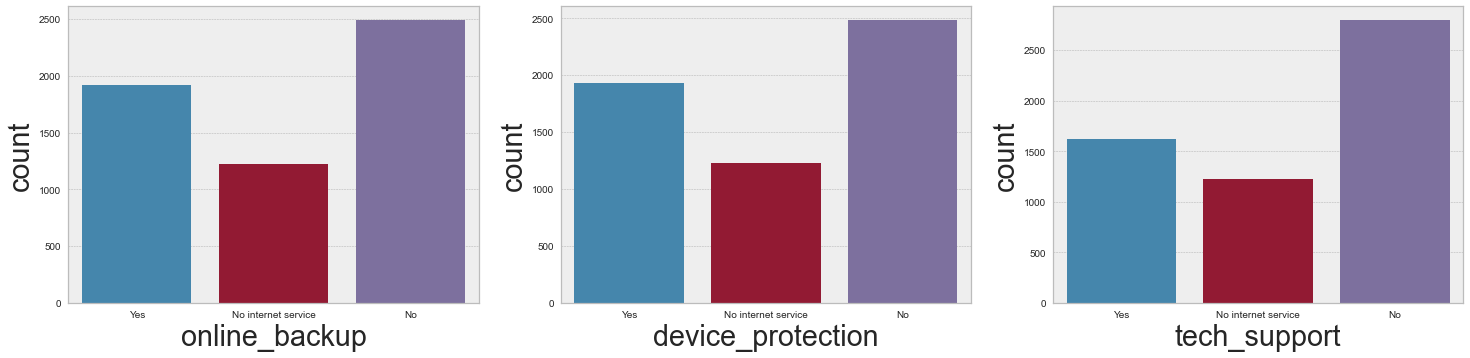

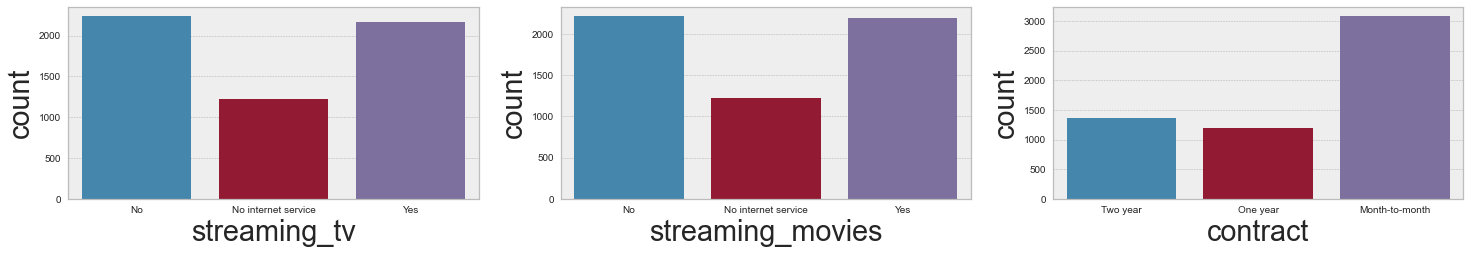

In [23]:
plt.subplot(1, 3, 1)
sns.countplot(df1['multiple_lines'])

plt.subplot(1, 3, 2)
sns.countplot(df1['internet_service'])

plt.subplot(1, 3, 3)
sns.countplot(df1['online_security'])
plt.show()

plt.subplot(2, 3, 1)
sns.countplot(df1['online_backup'])

plt.subplot(2, 3, 2)
sns.countplot(df1['device_protection'])

plt.subplot(2, 3, 3)
sns.countplot(df1['tech_support'])
plt.show()

plt.subplot(3, 3, 1)
sns.countplot(df1['streaming_tv'])

plt.subplot(3, 3, 2)
sns.countplot(df1['streaming_movies'])

plt.subplot(3, 3, 3)
sns.countplot(df1['contract'])
plt.show()

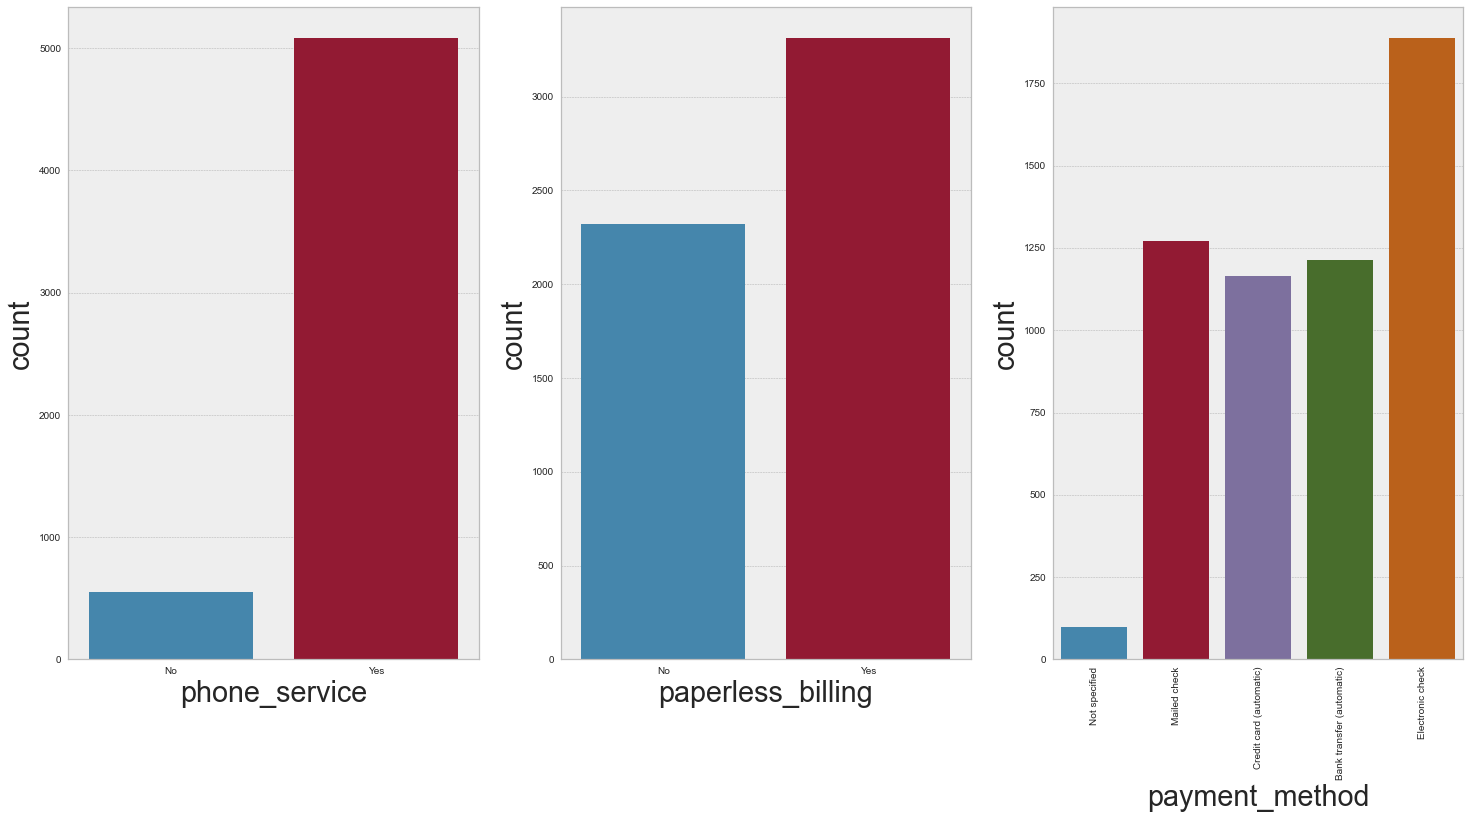

In [24]:
plt.subplot(1, 3, 1)
sns.countplot(df1['phone_service'])

plt.subplot(1, 3, 2)
sns.countplot(df1['paperless_billing'])

plt.subplot(1, 3, 3)
sns.countplot(df1['payment_method'])
plt.xticks(rotation=90)
plt.show()

In [25]:
cat_attibutes_list = cat_attributes.columns.tolist()
corr_dict = {}
for i in range(len(cat_attibutes_list)):
    corr_list=[]
    for j in range(len(cat_attibutes_list)):
        ref = cat_attibutes_list[i]
        feat = cat_attibutes_list[j]
        #correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        #append to list
        corr_list.append(corr)
    #append a correlation list for each ref attribute
    corr_dict[ref] = corr_list

<AxesSubplot:>

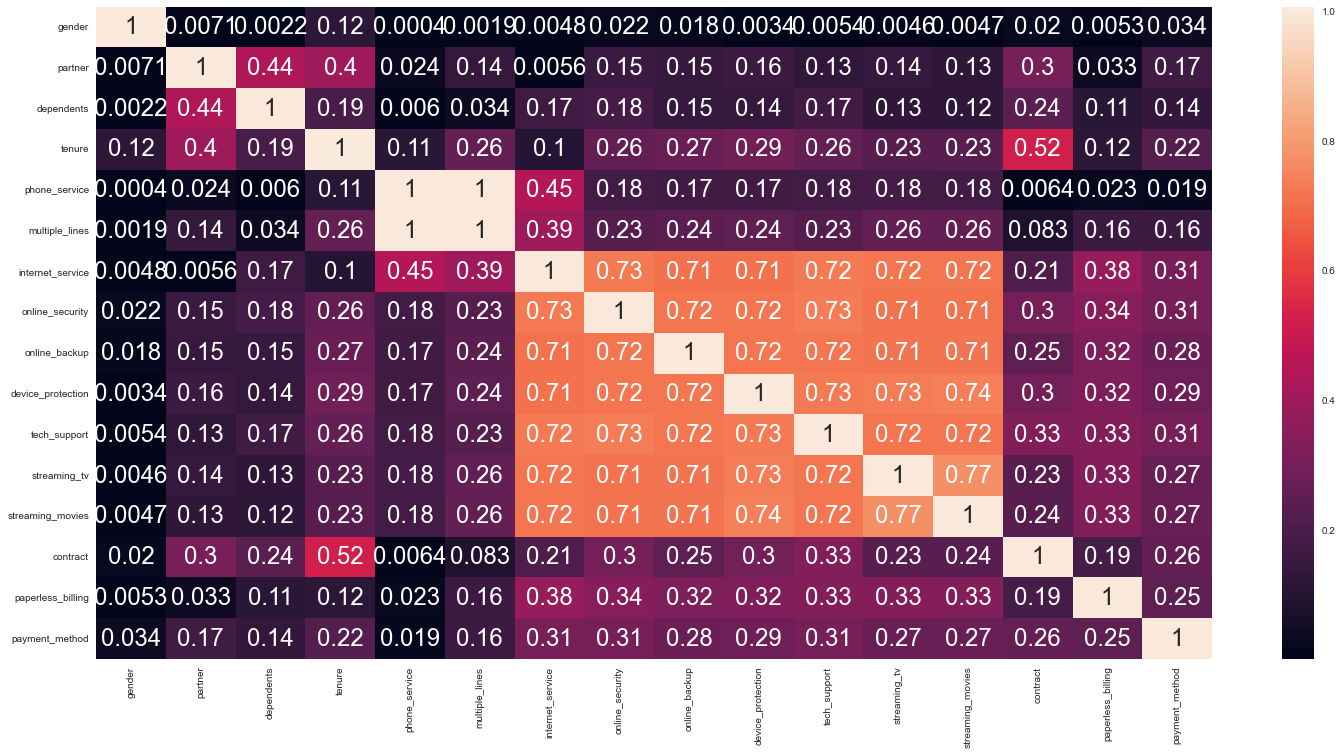

In [26]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 2.0 Feature Engineering

In [27]:
df2 = df1.copy()

In [28]:
#Enconding
le = LabelEncoder()

#phone_service
df2['phone_service'] = le.fit_transform(df2['phone_service'])

#multiple_lines
multiple_lines_dict = {'No phone service': 0,
                       'No': 0, 
                       'Yes': 1}
df2['multiple_lines'] = df2['multiple_lines'].map(multiple_lines_dict)

#internet_service
internet_service_dict = {'DSL': 1,
                         'No': 0, 
                         'Fiber optic': 1}
df2['internet_service'] = df2['internet_service'].map(internet_service_dict)

#online_security
online_security_dict = {'Yes': 1,
                         'No': 0, 
                         'No internet service': 0}
df2['online_security'] = df2['online_security'].map(online_security_dict)

#online_backup
online_backup_dict = {'Yes': 1,
                      'No': 0, 
                      'No internet service': 0}
df2['online_backup'] = df2['online_backup'].map(online_backup_dict)

#device_protection
device_protection_dict = {'Yes': 1,
                          'No': 0, 
                          'No internet service': 0}
df2['device_protection'] = df2['device_protection'].map(device_protection_dict)

#tech_support
tech_support_dict = {'Yes': 1,
                    'No': 0, 
                    'No internet service': 0}
df2['tech_support'] = df2['tech_support'].map(tech_support_dict)

#streaming_tv
streaming_tv_dict = {'Yes': 1,
                    'No': 0, 
                    'No internet service': 0}
df2['streaming_tv'] = df2['streaming_tv'].map(streaming_tv_dict)

#streaming_movies
streaming_movies_dict = {'Yes': 1,
                    'No': 0, 
                    'No internet service': 0}
df2['streaming_movies'] = df2['streaming_movies'].map(streaming_movies_dict)

In [29]:
#years customer is a client
df2['years_customer'] = (df2['tenure']/12).astype(int)

#total amount of services
df2['total_services'] = df2['phone_service'] + df2['multiple_lines'] + df2['internet_service'] + df2['online_security'] + df2['online_backup'] + df2['device_protection'] + df2['tech_support'] + df2['streaming_tv'] + df2['streaming_movies']

# 3.0 Balanced Dataset

In [30]:
df3 = df2.drop(columns=['id']).copy()

In [31]:
#enconding categorical features
#gender
df3['gender'] = le.fit_transform(df3['gender'])

#partner
df3['partner'] = le.fit_transform(df3['partner'])

#dependents
df3['dependents'] = le.fit_transform(df3['dependents'])

#contract
df3['contract'] = le.fit_transform(df3['contract'])

#paperless_billing
df3['paperless_billing'] = le.fit_transform(df3['paperless_billing'])

#payment_method
df3['payment_method'] = le.fit_transform(df3['payment_method'])

## 3.1 Random Undersampling 

In [32]:
#define sampler
undersampling = us.RandomUnderSampler(sampling_strategy='majority', random_state=32)

#apply sampler
X_under, y_under = undersampling.fit_resample(df3, df3['churn'])

In [33]:
df3['churn'].value_counts()

0    4139
1    1495
Name: churn, dtype: int64

In [34]:
y_under.value_counts()

0    1495
1    1495
Name: churn, dtype: int64

## 3.2 Random Oversampling 

In [35]:
#define sampler
oversampling = oversamp.RandomOverSampler(sampling_strategy='minority', random_state=32)

#apply sampler
X_over, y_over = oversampling.fit_resample(df3, df3['churn'])

In [36]:
df3['churn'].value_counts()

0    4139
1    1495
Name: churn, dtype: int64

In [37]:
y_over.value_counts()

0    4139
1    4139
Name: churn, dtype: int64

## 3.3 SMOTE + TOMEKLINK

In [38]:
#define sampler
#smt = c.SMOTETomek(sampling_strategy='auto', random_state=32, n_jobs=-1)

#apply sampler
#X_smt, y_smt = smt.fit_resample(df3, df3['churn'])

In [39]:
#df3['churn'].value_counts()

In [40]:
#y_smt.value_counts()

# 4.0 Exploratory Data Analysis

In [41]:
#total_charges NaN > replace for 0
df3.loc[df3['total_charges'].isna(), 'total_charges'] = 0

In [42]:
df4 = df3.copy()

In [43]:
#define sampler
smt = c.SMOTETomek(sampling_strategy='auto', random_state=32, n_jobs=-1)

#apply sampler
X_smt, y_smt = smt.fit_resample(df3, df3['churn'])

In [44]:
profile = ProfileReport(df4)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
#High Correlation
#years_customer x tenure
#remove: years_customer

## 4.1 Hypothesis Mind Map

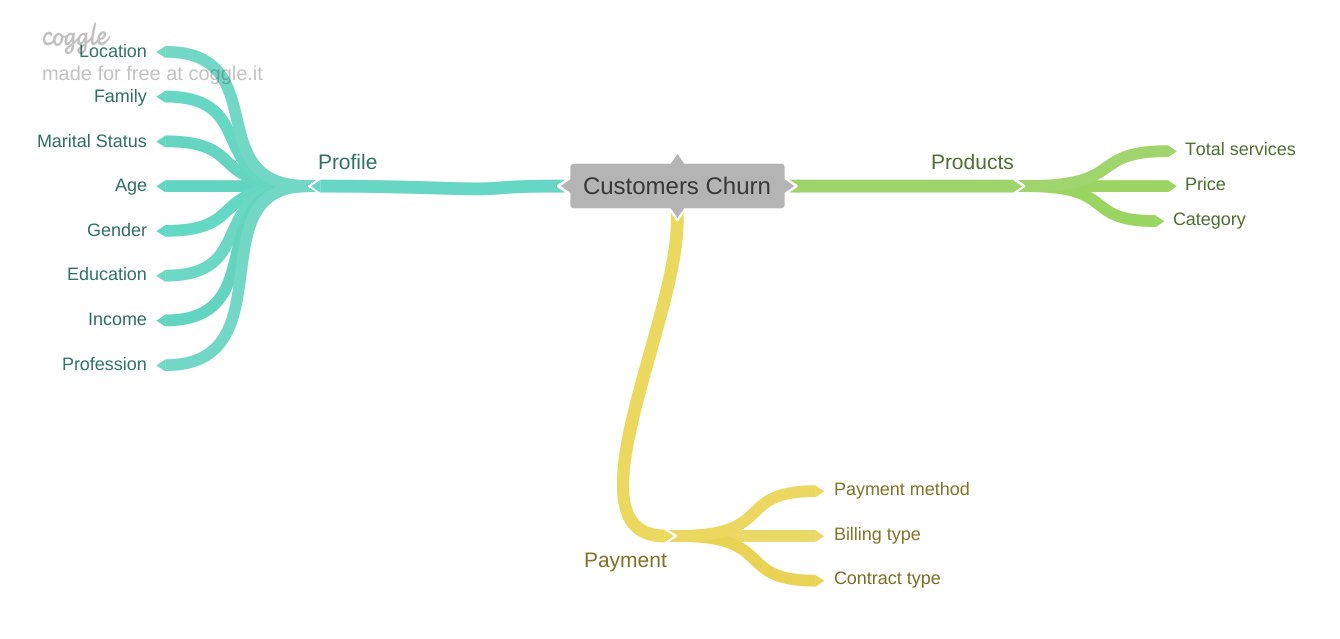

In [46]:
Image('img/Customers_Churn_Mindmap.png')

## 4.2 Hypothesis 

### H1  Senior customers have been customers for longer time
***TRUE*** Senior people have been customers for longer time.

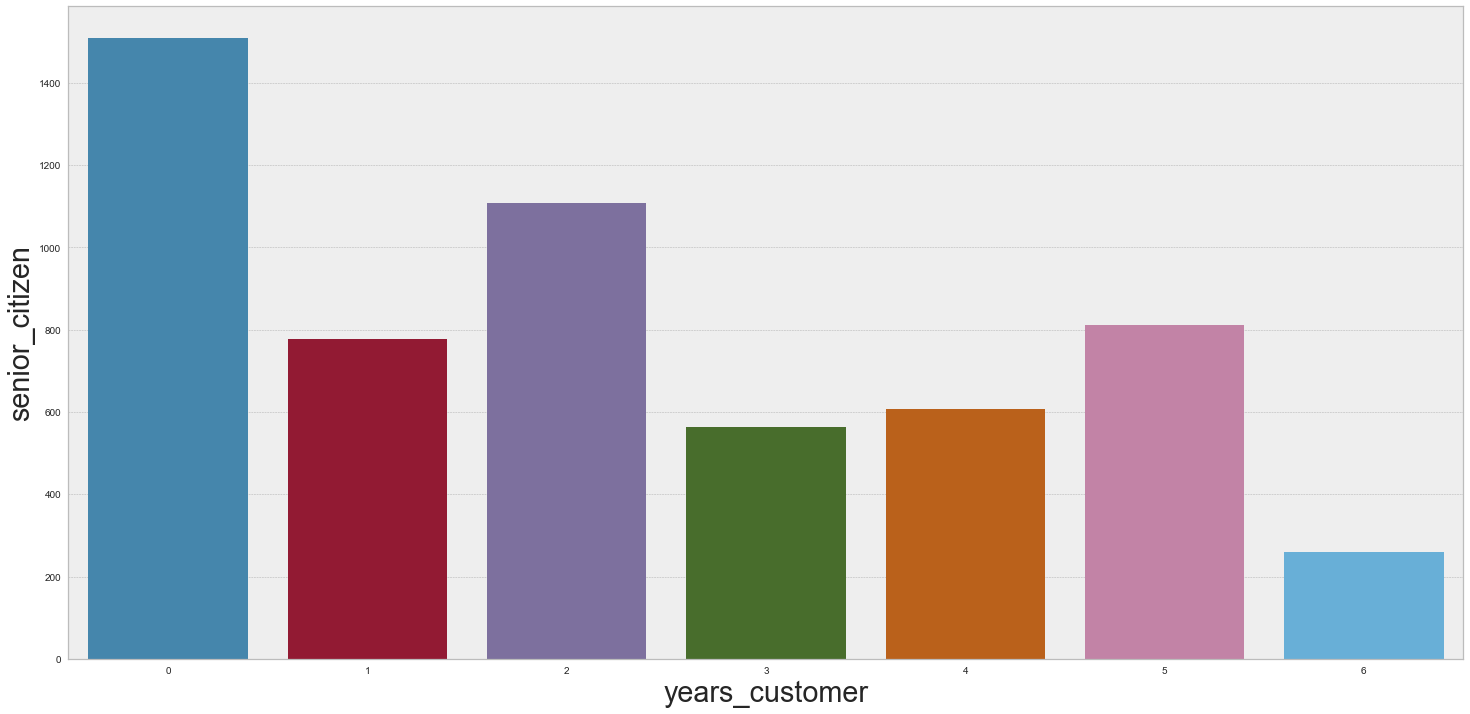

In [47]:
aux01 = df4[['senior_citizen', 'years_customer']].groupby('years_customer').count().reset_index().sort_values('senior_citizen', ascending=False)
sns.barplot(x='years_customer', y='senior_citizen', data=aux01);

In [48]:
aux011 = df4[['senior_citizen', 'years_customer']].groupby('senior_citizen').mean().reset_index().sort_values('years_customer', ascending=False)
aux011
#sns.barplot(x='years_customer', y='senior_citizen', data=aux011);

senior_citizen  years_customer
1               1            2.29
0               0            2.25

### H2 Customers with partners and dependents have more services than customer with partners only 
***FALSE*** Customers with partners only have more services than customers with partners and dependents.

In [49]:
p_and_d = df4.loc[(df4['partner'] == 1) & (df4['dependents'] == 1)]
p_only = df4.loc[df4['partner'] == 1]
cust_only = df4.loc[(df4['partner'] == 0) & (df4['dependents'] == 0)]

h2_dict = {'Customers w/ partner and dependents': p_and_d['total_services'].sum(),
          'Customers w/ partner only': p_only['total_services'].sum(),
          'Customers only': cust_only['total_services'].sum()}
aux02 = pd.DataFrame.from_dict(h2_dict, orient='index').T

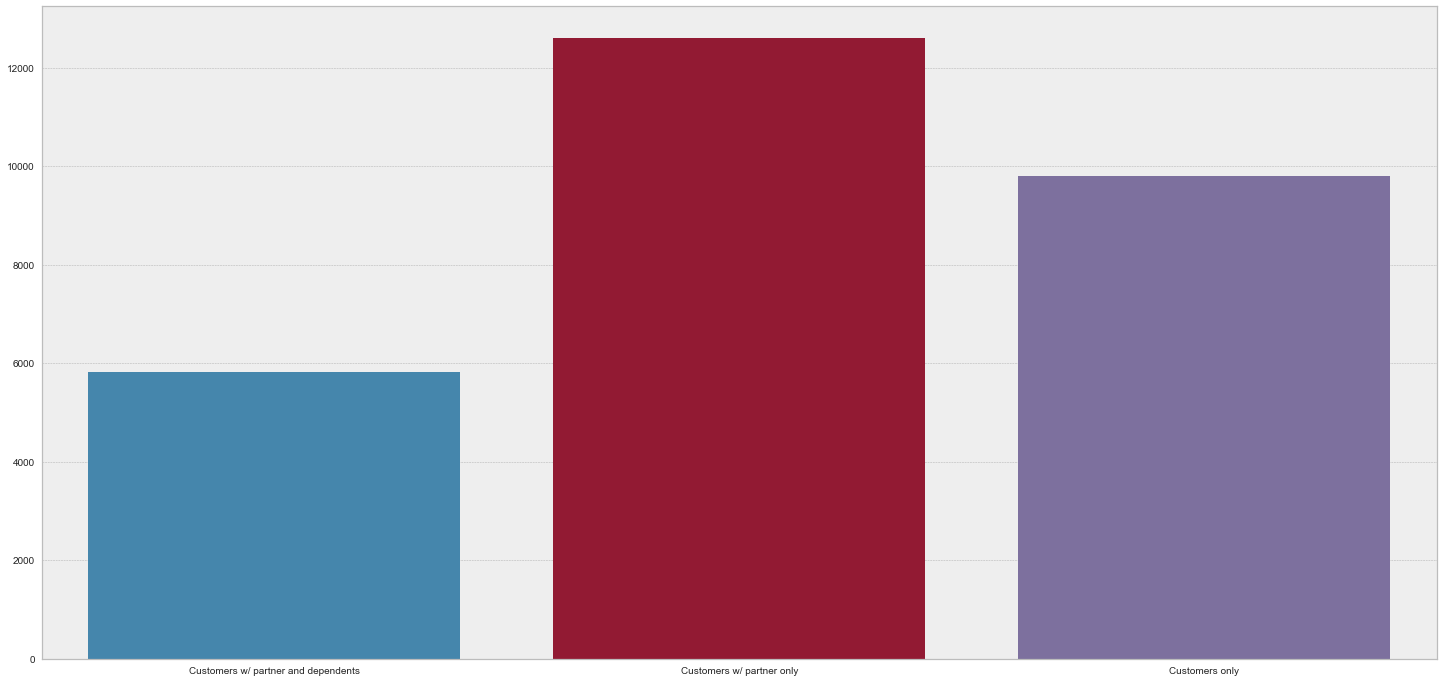

In [50]:
sns.barplot(data=aux02);

### H3 Customers with more services have been customers for a longer time
***TRUE*** Customers with more services have been customers for 5 years in average.

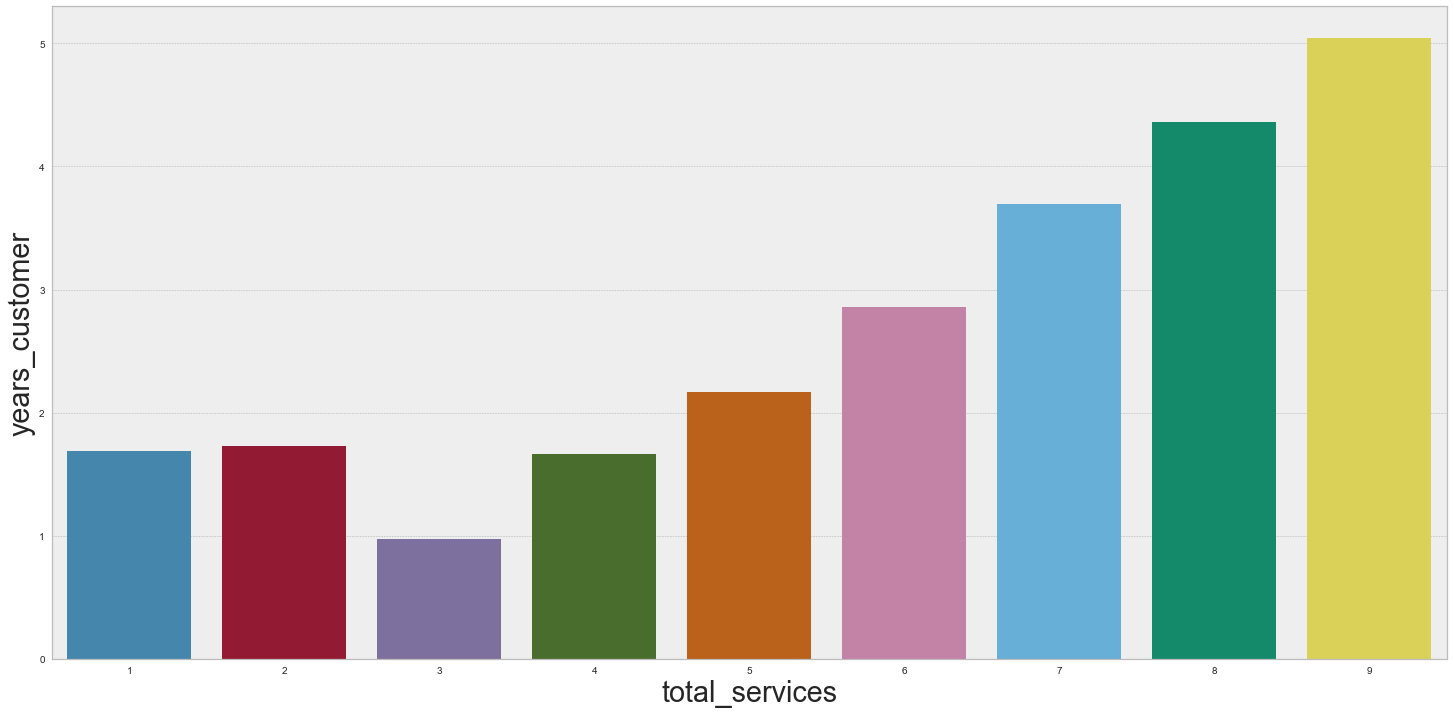

In [51]:
aux03 = df4[['total_services', 'years_customer']].groupby('total_services').mean().reset_index().sort_values('years_customer', ascending=False)
sns.barplot(x='total_services', y='years_customer', data=aux03);

### H4 Customers with monthly contract have more churn rate then others contract methods
***TRUE*** Churn rate is bigger for customers with month-to-month contract

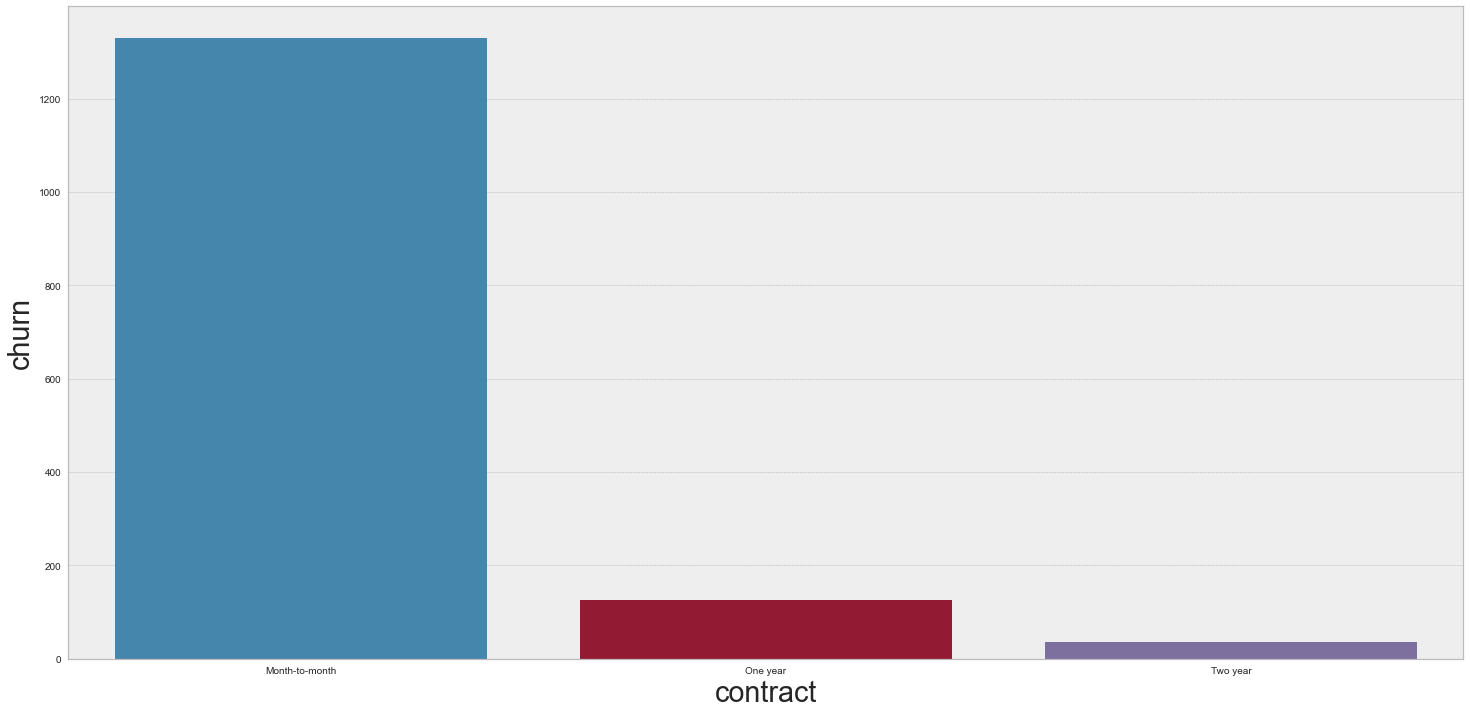

In [52]:
aux04 = df2[['contract', 'churn']].groupby('contract').sum().reset_index().sort_values('churn', ascending=False)
sns.barplot(x='contract', y='churn', data=aux04);

### H5 Bigger total charges leads to bigger churn rate
***FALSE*** Customers with churn have lower total charges

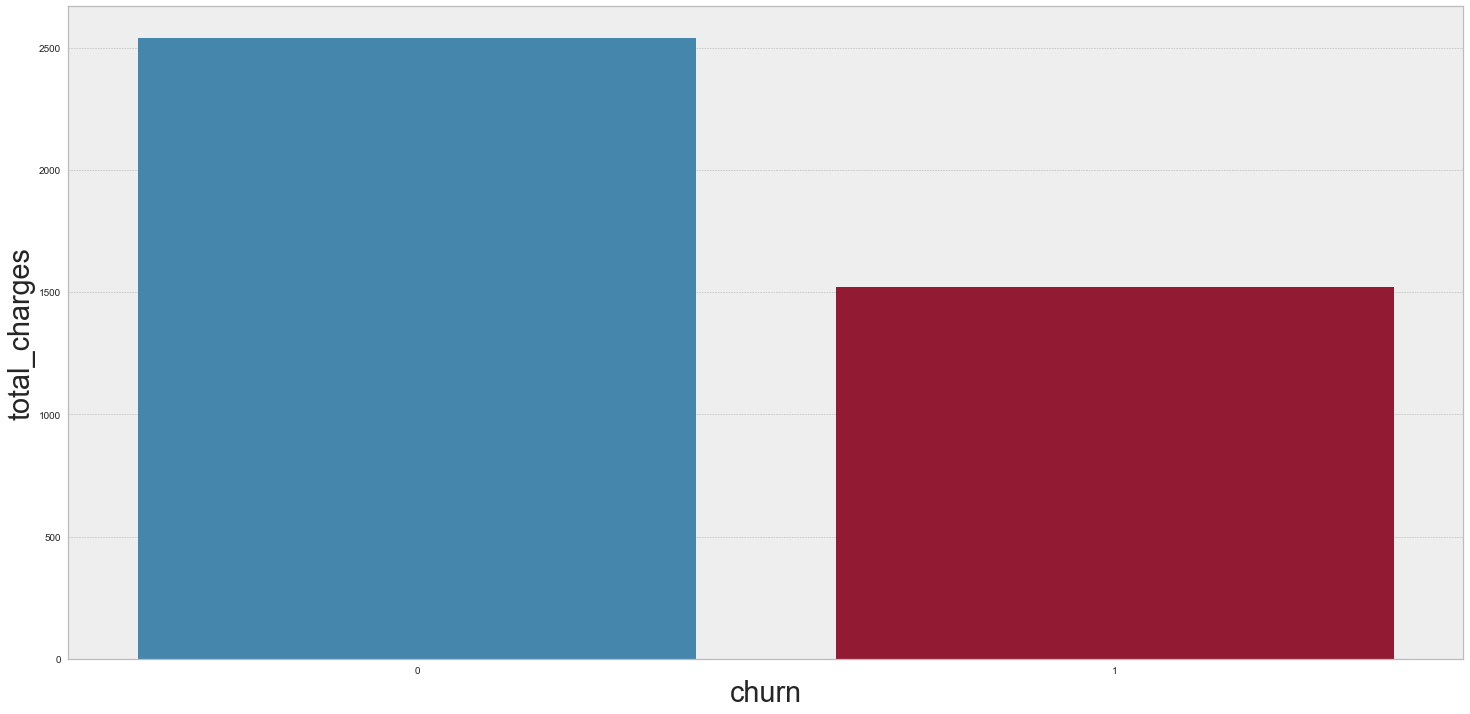

In [53]:
aux05 = df4[['total_charges', 'churn']].groupby('churn').mean().reset_index()
sns.barplot(x='churn', y='total_charges', data=aux05);

### H6 Monthly_charges are bigger for customers with churn
***TRUE*** Average monthly charges are bigger within customers that jave churned

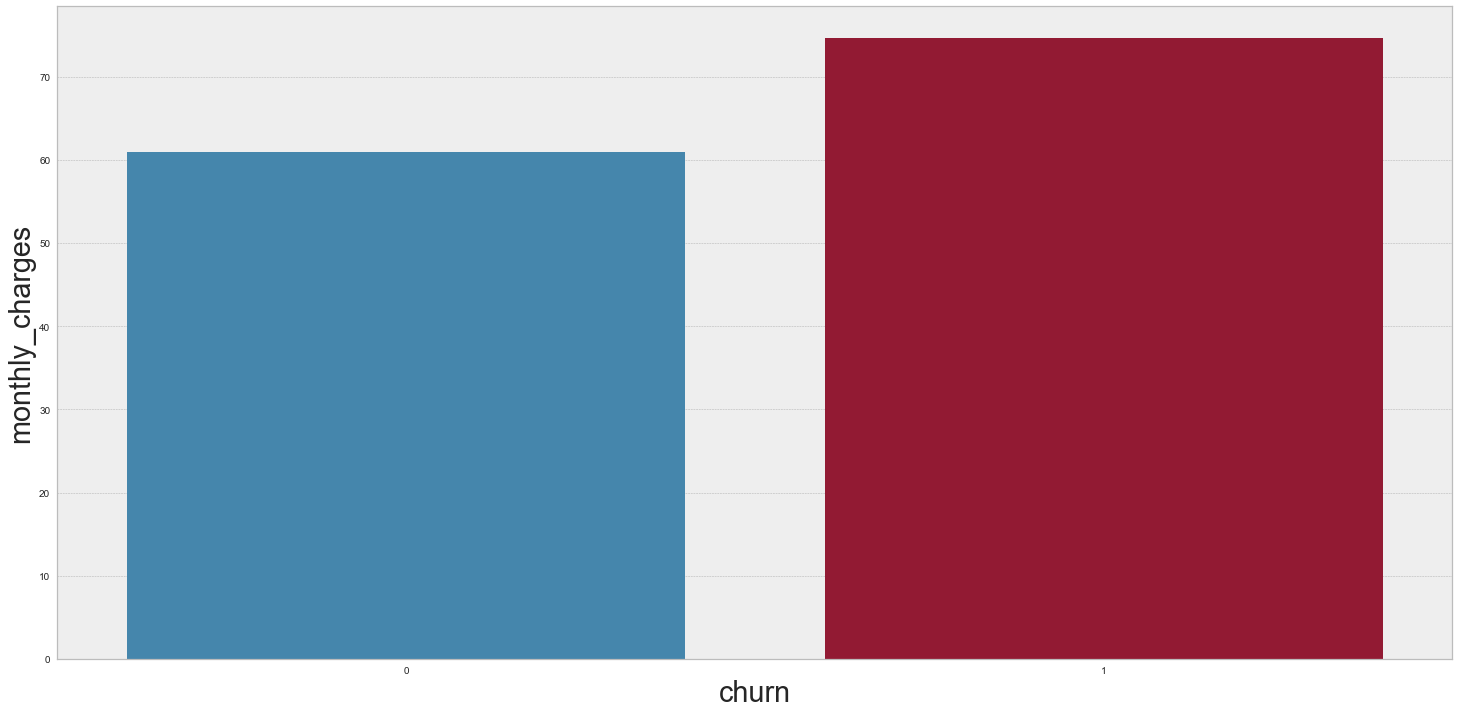

In [54]:
aux06 = df4[['monthly_charges', 'churn']].groupby('churn').mean().reset_index()
sns.barplot(x='churn', y='monthly_charges', data=aux06);

### H7 Credit card is the most used payment method
***FALSE*** Eletronic check is the most used payment method

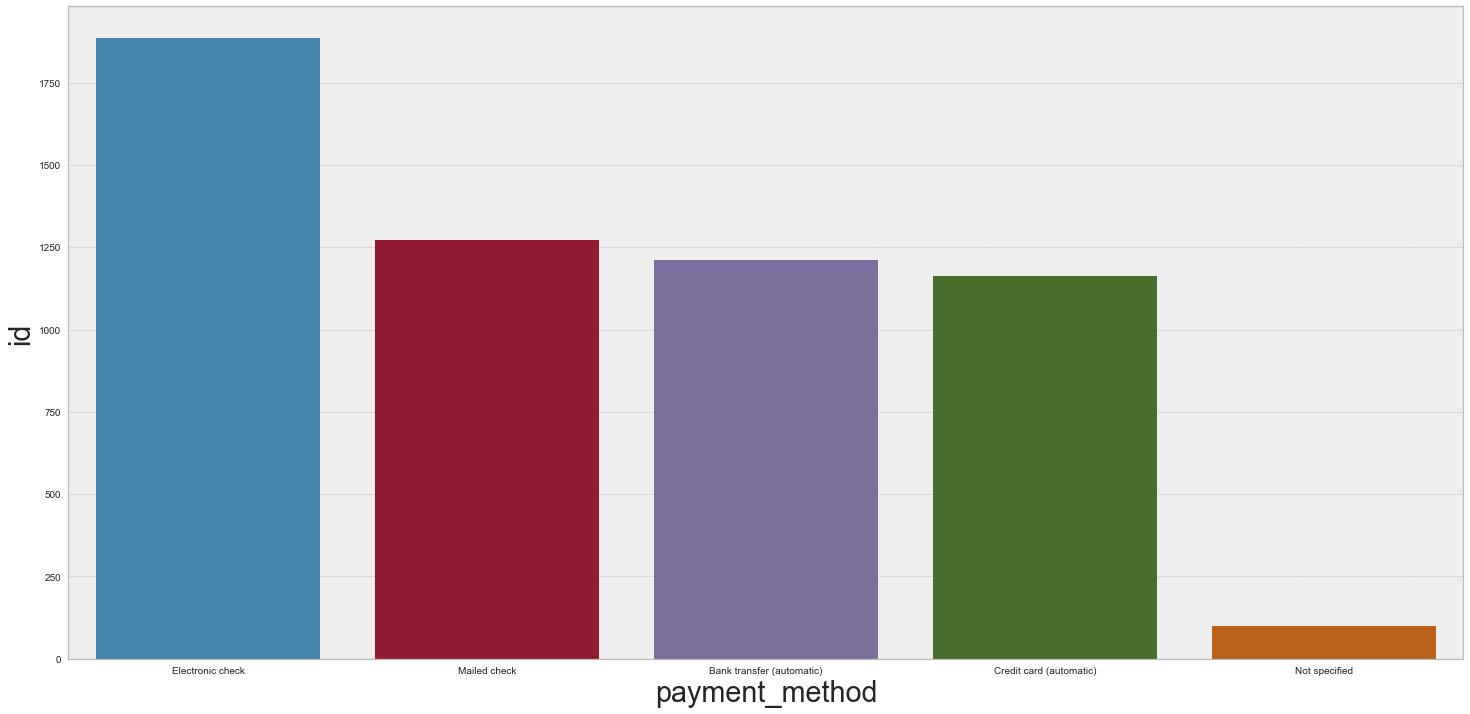

In [55]:
aux07 = df2[['payment_method', 'id']].groupby('payment_method').count().reset_index().sort_values('id', ascending=False)
sns.barplot(x='payment_method', y='id', data=aux07);

# 5.0 Data Preparation

In [56]:
#df5 = df4.drop(columns=['years_customer']).copy()
df5 = X_smt.drop(columns=['years_customer', 'total_services']).copy()

In [57]:
rs = RobustScaler()
#rescaling
df5['tenure'] = rs.fit_transform(df5[['tenure']].values)
df5['monthly_charges'] = rs.fit_transform(df5[['monthly_charges']].values)
df5['total_charges'] = rs.fit_transform(df5[['total_charges']].values)

In [58]:
#aux = df2[['id', 'total_charges']]
#aux['delta'] = aux['total_charges'].pct_change()

# 6.0 ML Models

In [103]:
df6 = df5.copy()

In [104]:
#train and test dataset
X_train, X_test, y_train, y_test = train_test_split(df6, df6['churn'], test_size=0.2, random_state=42)

In [105]:
#feature selection
selected = ['gender', 'senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines', 'internet_service',
            'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
            'payment_method', 'monthly_charges', 'total_charges']

#columns to add
feat_to_add = ['churn']
cols_full = selected.copy()
cols_full.extend(feat_to_add)

In [106]:
x_train = X_train[selected]
x_test = X_test[selected]

#cross validation
x_training = X_train[cols_full]

## 6.1 ML Pipeline 

In [63]:
model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear'))
model_pipeline.append(RidgeClassifier())
model_pipeline.append(SVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())

## 6.2 ML Evaluation 

In [64]:
model_list = ['Logistic Regression', 'Ridge Classifier', 'SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Naive Bayes']
acc_list = []
auc_list = []
cm_list = []
fscore_list = []
balancedacc_list = []
kappa_list = []

for model in model_pipeline:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc_list.append(accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = roc_curve(y_test, y_pred)
    auc_list.append(round(m.auc(fpr, tpr), 2))
    fscore_list.append(f1_score(y_test, y_pred))
    balancedacc_list.append(balanced_accuracy_score(y_test, y_pred))
    kappa_list.append(cohen_kappa_score(y_test, y_pred))
    cm_list.append(confusion_matrix(y_test, y_pred))

## 6.3 Plot Confusion Matrix

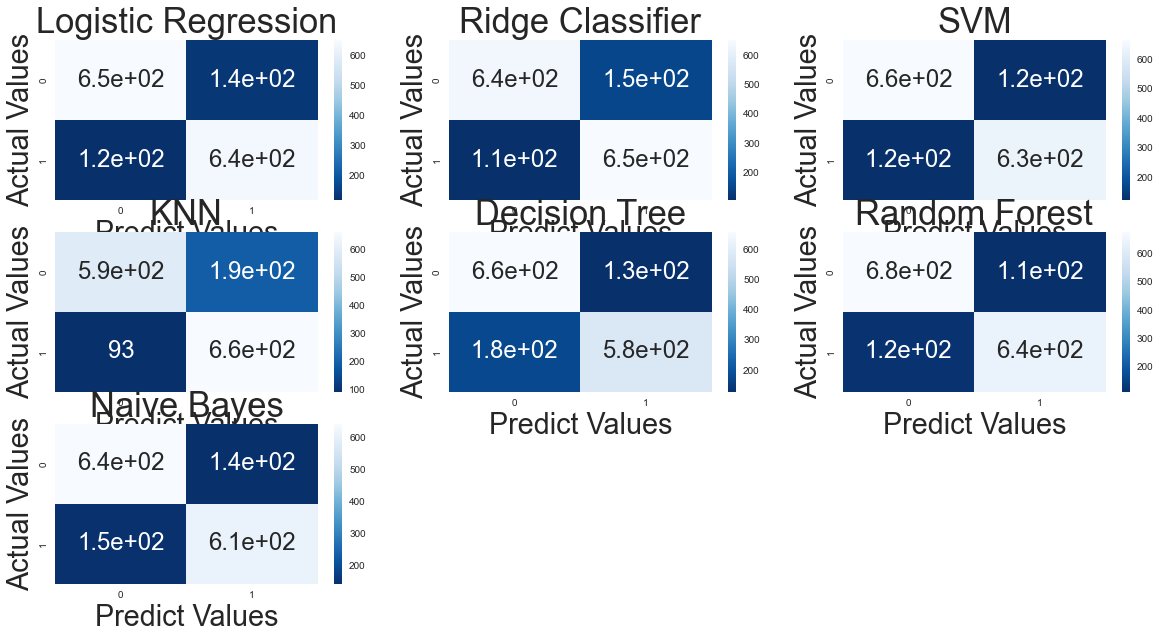

In [65]:
fig = plt.figure(figsize=(20,10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(3, 3, i+1).set_title(model)
    cm_plot = sns.heatmap(cm, annot=True, cmap='Blues_r')
    cm_plot.set_xlabel('Predict Values')
    cm_plot.set_ylabel('Actual Values')

## 6.4 Accuracy and AUC

In [66]:
result_df = pd.DataFrame({'Model': model_list, 'Accuracy': acc_list, 'AUC': auc_list, 'F1-Score': fscore_list, 'Balanced Accuracy': balancedacc_list, 'Kappa Score': kappa_list})
result_df.style.highlight_max(color = 'lightgreen', axis = 0)

## 6.5 Cross-Validation 

In [67]:
lr_cv = cross_validation('Logistic Regression', LogisticRegression(solver='liblinear'))

In [68]:
rc_cv = cross_validation('Ridge Classifier', RidgeClassifier())

In [69]:
svm_cv = cross_validation('SVM', SVC())

In [70]:
knn_cv = cross_validation('KNN', KNeighborsClassifier())

In [71]:
dt_cv = cross_validation('Decision Tree', DecisionTreeClassifier())

In [72]:
rf_cv = cross_validation('Random Forest', RandomForestClassifier())

In [73]:
nb_cv = cross_validation('Naive Bayes', GaussianNB())

In [74]:
modelling_result_cv = pd.concat([lr_cv, rc_cv, svm_cv, knn_cv, dt_cv, rf_cv, nb_cv])
modelling_result_cv.sort_values(by='ACC CV')

Model Name            ACC CV
0        Decision Tree  0.803 +/- 0.0128
0          Naive Bayes  0.811 +/- 0.0064
0                  KNN   0.811 +/- 0.008
0     Ridge Classifier  0.827 +/- 0.0064
0  Logistic Regression   0.832 +/- 0.006
0                  SVM  0.838 +/- 0.0086
0        Random Forest   0.851 +/- 0.003

# 7.0 Hyperparameter Tuning

In [75]:
rf = RandomForestClassifier(random_state=42)

In [77]:
print('Currently in use parameters: \n')
pprint(rf.get_params())

Currently in use parameters: 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [79]:
#number of trees
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=100)]
#number of features
max_features = ['auto', 'sqrt']
#max number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
#min number of samples to split node
min_samples_split = [2, 5, 10]
#min samples at each leaf node
min_samples_leaf = [1, 2, 4]
#samples selection method
bootstrap = [True, False]

#create random grid
random_grid = {'bootstrap': bootstrap,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split,
               'n_estimators': n_estimators}

In [80]:
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs=-1)

#fit random search model
#rf_random.fit(x_train, y_train)

In [81]:
#rf_random.best_params_

#{'n_estimators': 1054,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

IndentationError: unexpected indent (<ipython-input-81-8965183f4bcd>, line 4)

## 7.1 Final Model

In [86]:
tunned_acc_list = []
tunned_auc_list = []
tunned_cm_list = []
tunned_fscore_list = []
tunned_balancedacc_list = []
tunned_kappa_list = []

In [87]:
#model definition
rf_tunned = RandomForestClassifier(random_state=42, n_estimators=1054, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=20, bootstrap=True).fit(x_train, y_train)

#predict
y_pred = rf_tunned.predict(x_test)

#performance
tunned_acc_list.append(accuracy_score(y_test, y_pred))
fpr, tpr, _thresholds = roc_curve(y_test, y_pred)
tunned_auc_list.append(round(m.auc(fpr, tpr), 2))
tunned_fscore_list.append(f1_score(y_test, y_pred))
tunned_balancedacc_list.append(balanced_accuracy_score(y_test, y_pred))
tunned_kappa_list.append(cohen_kappa_score(y_test, y_pred))
tunned_cm_list.append(confusion_matrix(y_test, y_pred))

Text(160.0, 0.5, 'Actual Values')

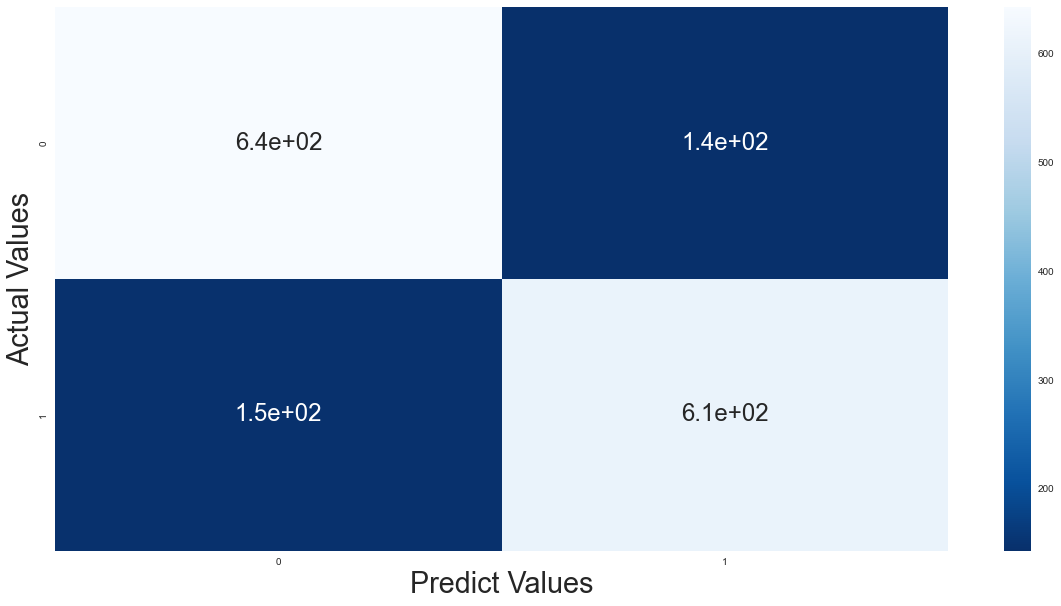

In [88]:
#confusion matrix
fig = plt.figure(figsize=(20,10))
cm_plot = sns.heatmap(cm, annot=True, cmap='Blues_r')
cm_plot.set_xlabel('Predict Values')
cm_plot.set_ylabel('Actual Values')

In [90]:
#results
result_df_tunned = pd.DataFrame({'Model': 'Random Forest Tunned', 'Accuracy': tunned_acc_list, 'AUC': tunned_auc_list, 'F1-Score': tunned_fscore_list, 'Balanced Accuracy': tunned_balancedacc_list, 'Kappa Score': tunned_kappa_list})
result_df_tunned

Model  Accuracy  AUC  F1-Score  Balanced Accuracy  Kappa Score
0  Random Forest Tunned      0.86 0.86      0.86               0.86         0.72